In [21]:
!pip install torch==2.4.0 torchvision==0.19.0 torchaudio==2.4.0 --index-url https://download.pytorch.org/whl/cu121

In [22]:
!pip uninstall -y mamba-ssm causal-conv1d
!pip install causal-conv1d mamba-ssm --no-build-isolation
!pip install fast-ctc-decode
!pip install peft ninja packaging jiwer

In [3]:
cp -r /kaggle/input/mambaocr/ocr_project /kaggle/working/

CG03BX1873_77811.jpg  →  CG03BX1873
MN88KG0621_32919.jpg  →  MN88KG0621
GJ72UV1362_28409.jpg  →  GJ72UV1362
MZ99DY1436_57430.jpg  →  MZ99DY1436
MH07TK5904_79107.jpg  →  MH07TK5904
GA82YI39714_65160.jpg  →  GA82YI39714


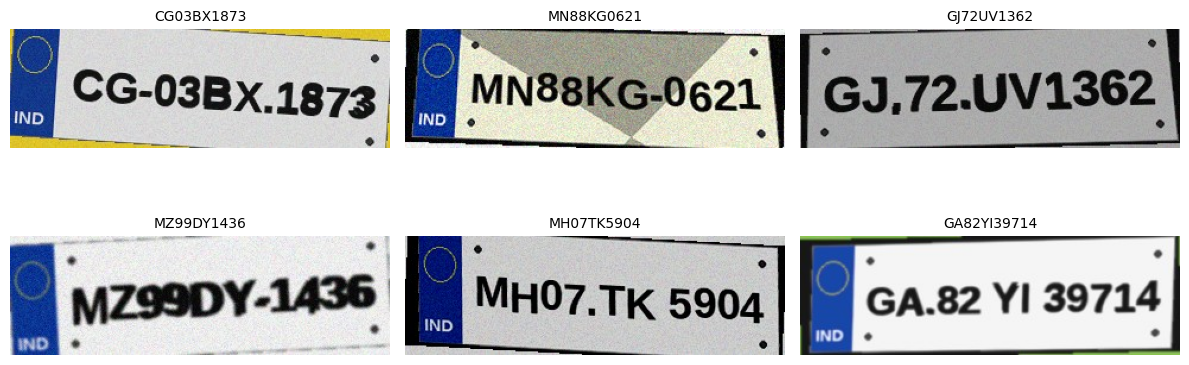

AN76SA9849_13579.jpg  →  AN76SA9849
AP37VY9608_12881.jpg  →  AP37VY9608
UP29IP422_5646.jpg  →  UP29IP422
TS35PP88149_29026.jpg  →  TS35PP88149
MN53FV3321_73383.jpg  →  MN53FV3321
UP83LX1292_65927.jpg  →  UP83LX1292


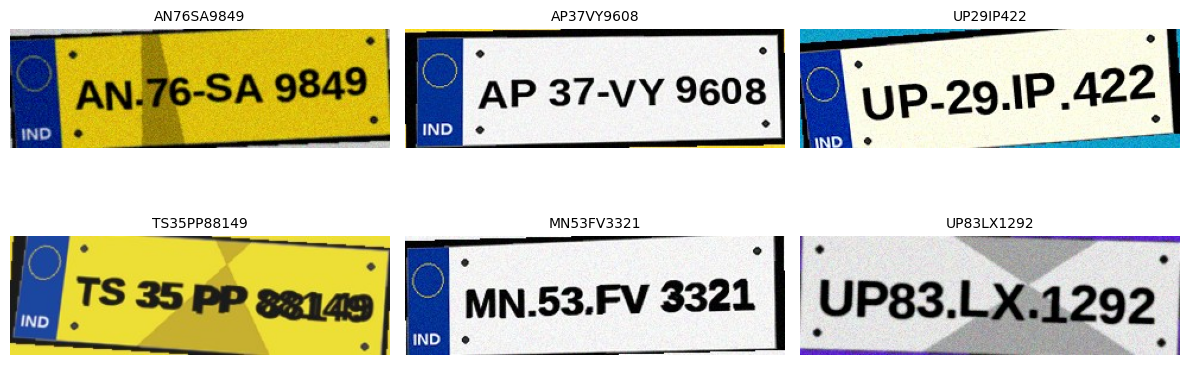

HR56_46540.jpg  →  HR56
DL45IC8657_67337.jpg  →  DL45IC8657
AS06HN5039_30008.jpg  →  AS06HN5039
OD22VQ1429_17352.jpg  →  OD22VQ1429
CH46_70697.jpg  →  CH46
DN27_397.jpg  →  DN27


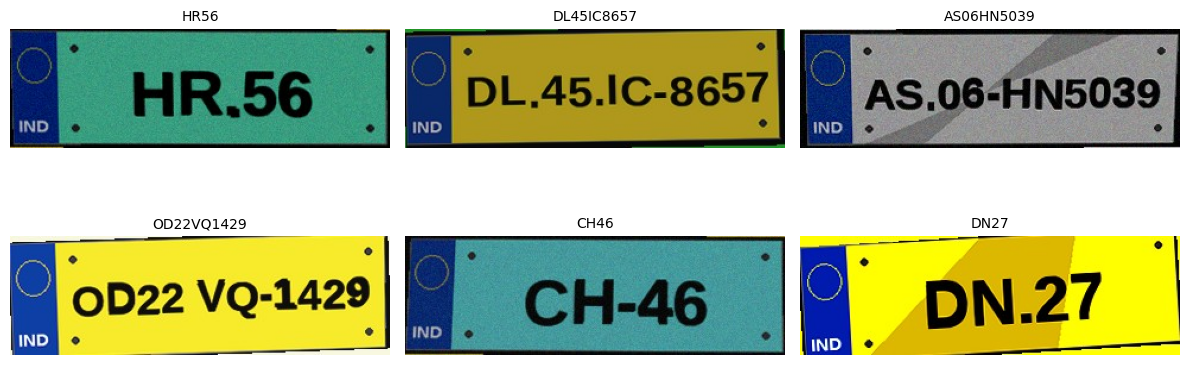

In [4]:
import os
import random
import csv
import matplotlib.pyplot as plt
from PIL import Image

IMAGE_DIR = "/kaggle/input/synth-platev1/images"
LABELS_CSV = "/kaggle/input/synth-platev1/labels.csv"
BATCH_SIZE = 6
ROWS = 2
COLS = 3

def load_labels(csv_path):
    label_map = {}
    with open(csv_path, newline="", encoding="utf-8") as f:
        reader = csv.DictReader(f)
        for row in reader:
            label_map[os.path.basename(row["filename"])] = row["label"]
    return label_map

def view_random_images_with_labels(folder, csv_path, n_batches=3):
    label_map = load_labels(csv_path)

    images = [
        f for f in os.listdir(folder)
        if f in label_map and f.lower().endswith((".png", ".jpg", ".jpeg"))
    ]

    if not images:
        print("❌ No images found")
        return

    for _ in range(n_batches):
        batch = random.sample(images, min(BATCH_SIZE, len(images)))

        fig, axes = plt.subplots(ROWS, COLS, figsize=(12, 5))
        axes = axes.flatten()

        for ax in axes:
            ax.axis("off")

        for i, fname in enumerate(batch):
            img_path = os.path.join(folder, fname)
            img = Image.open(img_path)
            label = label_map[fname]

            axes[i].imshow(img)
            axes[i].set_title(label, fontsize=10)

            print(f"{fname}  →  {label}")

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    view_random_images_with_labels(IMAGE_DIR, LABELS_CSV)


In [5]:
%%writefile /kaggle/working/ocr_project/data/augmentations.py
import albumentations as A
import cv2

def get_train_transforms():
    """
    Cleaned Augmentation pipeline compatible with newer Albumentations versions.
    """
    return A.Compose([
        # 1. Geometry
        # removed 'value=0' (defaults to black anyway)
        A.Rotate(limit=10, p=0.5, border_mode=cv2.BORDER_CONSTANT),
        
        # removed 'pad_mode'/'pad_val' (defaults to black/constant)
        A.Perspective(scale=(0.02, 0.05), p=0.3),

        # 2. Blur & Noise
        A.OneOf([
            A.MotionBlur(blur_limit=5, p=1.0),
            A.GaussianBlur(blur_limit=(3, 5), p=1.0),
            A.MultiplicativeNoise(multiplier=[0.8, 1.2], elementwise=True, p=1.0),
        ], p=0.5),

        # 3. Occlusions
        # Simplified parameters to avoid version conflicts
        A.CoarseDropout(max_holes=6, max_height=8, max_width=8, p=0.3),

        # 4. Lighting
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    ])

Overwriting /kaggle/working/ocr_project/data/augmentations.py


In [6]:
%%writefile /kaggle/working/ocr_project/data/dataset.py

import torch
from torch.utils.data import Dataset
import numpy as np
import cv2
import os
import pandas as pd
import re
from tqdm import tqdm
from .augmentations import get_train_transforms

def load_data(cfg):
    """
    Robust data loader. 
    1. Checks for config paths.
    2. Filters missing images.
    """
    image_paths = []
    labels = []

    # Decide which file to load based on Config (Synth vs Real)
    # Priority: train_csv (Real) -> labels_file (Synth)
    if hasattr(cfg, 'train_csv') and os.path.exists(cfg.train_csv):
        target_file = cfg.train_csv
        print(f"Loading Real Data from: {target_file}")
        df = pd.read_csv(target_file)
    elif hasattr(cfg, 'labels_file') and os.path.exists(cfg.labels_file):
        target_file = cfg.labels_file
        print(f"Loading Synthetic Data from: {target_file}")
        # Assuming space separated txt for synthetic
        try:
            df = pd.read_csv(target_file, sep=" ", header=None, names=["filename", "label"])
        except:
             # Fallback if it's actually a CSV
             df = pd.read_csv(target_file)
    else:
        raise FileNotFoundError(" No valid labels file found in Config paths.")

    # Iterate and Validate
    valid_count = 0
    
    # Check if 'dir_path' column exists (for merged datasets)
    has_dir_col = 'dir_path' in df.columns
    
    for _, row in df.iterrows():
        fname = str(row["filename"])
        label = str(row["label"])
        
        # Skip bad labels
        if label.lower() == 'nan': continue

        # # Resolve Path
        # if has_dir_col and pd.notna(row['dir_path']):
        #      full_path = os.path.join(row['dir_path'], fname)
        # elif hasattr(cfg, 'images_dir'):
        #      full_path = os.path.join(cfg.images_dir, fname)
        # else:
        #      full_path = os.path.join(cfg.data_dir, "images", fname)
             
        # # Check existence (Optional: disable for massive speedup if confident)
        # if os.path.exists(full_path):
        #     image_paths.append(full_path)
        #     labels.append(label)
        #     valid_count += 1

        cleaned_fname = fname
        for prefix in ['images/', 'data/images/', './images/']:
            if cleaned_fname.startswith(prefix):
                cleaned_fname = cleaned_fname[len(prefix):]
                break

        # Resolve Path using the cleaned filename
        if has_dir_col and pd.notna(row['dir_path']):
             full_path = os.path.join(row['dir_path'], cleaned_fname)
        elif hasattr(cfg, 'images_dir'):
             full_path = os.path.join(cfg.images_dir, cleaned_fname)
        else:
             # Fallback if images_dir is not set
             full_path = os.path.join(cfg.data_dir, "images", cleaned_fname)
             
        # Check existence 
        if os.path.exists(full_path):
            image_paths.append(full_path)
            labels.append(label)
            valid_count += 1
            
    print(f"Loaded {valid_count} valid samples.")
    return image_paths, labels

class OCRDataset(Dataset):
    def __init__(self, cfg, is_train=True):
        self.cfg = cfg
        self.is_train = is_train
        
        # Load Data
        self.image_paths, self.labels = load_data(cfg)
        
        # Map Chars (0-9A-Z)
        self.char2idx = {c: i+1 for i, c in enumerate(cfg.vocab)}
        
        # Augmentations
        self.aug = get_train_transforms() if is_train else None

        # Caching Strategy
        # Only cache if dataset < 20k images to avoid RAM explosion
        self.use_cache = len(self.image_paths) < 20000
        
        if self.use_cache:
            print(f"⚡ Caching {len(self.image_paths)} images in RAM...")
            self.cached_images = []
            for p in tqdm(self.image_paths):
                img = self.load_image_file(p)
                self.cached_images.append(img)
        else:
            self.cached_images = None

    def load_image_file(self, path):
        try:
            img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
            if img is None: raise ValueError
            return img
        except:
            # Return Black Image on failure
            return np.zeros((self.cfg.img_height, self.cfg.img_width), dtype=np.uint8)

    def encode(self, text):
        """
        STRICT UPPERCASE ENFORCEMENT
        """
        # 1. Force Upper
        text = str(text).upper()
        
        # 2. Filter using Vocab (Keep only 0-9A-Z)
        text = re.sub(r'[^0-9A-Z]', '', text)
        
        # 3. Map to Index
        cleaned = [self.char2idx[c] for c in text if c in self.char2idx]
        
        # 4. Handle Empty
        if not cleaned: cleaned = [self.char2idx[self.cfg.vocab[0]]] 
        return torch.tensor(cleaned, dtype=torch.long)

    def resize_and_pad(self, img):
        """
        Resizes to height=32, preserves aspect ratio, then PADS width to 320.
        Essential for Batch Processing.
        """
        h, w = img.shape
        target_h, target_w = self.cfg.img_height, self.cfg.img_width # 32, 320
        
        # Scale to fixed height
        scale = target_h / h
        new_w = min(int(w * scale), target_w)
        img = cv2.resize(img, (new_w, target_h))
        
        # Pad Right side with Black (0) to match target_w
        delta_w = target_w - new_w
        if delta_w > 0:
            img = cv2.copyMakeBorder(img, 0, 0, 0, delta_w, cv2.BORDER_CONSTANT, value=0)
            
        return img

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # 1. Get Image
        if self.use_cache:
            img = self.cached_images[idx]
        else:
            img = self.load_image_file(self.image_paths[idx])

        # 2. Augment
        if self.is_train and self.aug:
            try: img = self.aug(image=img)["image"]
            except: pass

        # 3. Resize & Pad
        img = self.resize_and_pad(img)

        # 4. Normalize & Tensor
        img = img.astype(np.float32) / 255.0
        img = np.stack([img, img, img], axis=0) # [1,H,W] -> [3,H,W]
        
        mean = np.array(self.cfg.mean)[:, None, None]
        std = np.array(self.cfg.std)[:, None, None]
        img = (img - mean) / std
        
        # 5. Label
        label_text = self.labels[idx]
        target = self.encode(label_text)
        target_len = torch.tensor(len(target), dtype=torch.long)

        return torch.from_numpy(img).float(), target, target_len

Overwriting /kaggle/working/ocr_project/data/dataset.py


In [7]:
%%writefile /kaggle/working/ocr_project/configs/config.py
import torch
import os

class Config:
    def __init__(self):
        # ====================================================
        # 1. DATA PATHS (For your current Kaggle data)
        # ====================================================
        self.data_dir = "/kaggle/input/synth-platev1"
        self.images_dir = os.path.join(self.data_dir, "images")
        self.labels_file = os.path.join(self.data_dir, "labels.txt")
        
        self.checkpoint_dir = "/kaggle/working/checkpoints"
        self.best_model_path = os.path.join(self.checkpoint_dir, "best_mamba_ocr.pth")
        
        if not os.path.exists(self.checkpoint_dir):
             os.makedirs(self.checkpoint_dir, exist_ok=True)

        # ====================================================
        # 2. MODEL & VOCAB
        # ====================================================
        # STRICT VOCAB: 0-9 + A-Z (36 Char)
        self.vocab = "0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ"
        self.blank_idx = 0 
        
        self.img_height = 32
        self.img_width = 320
        
        # ImageNet Stats
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]

        # Architecture
        self.cnn_out = 512
        self.adapter_dim = 64
        self.mamba_pretrained = "state-spaces/mamba-130m-hf"
        self.mamba_layers = 6
        self.use_lora = True
        self.lora_rank = 64
        self.mamba_dropout = 0.1

        # ====================================================
        # 3. TRAINING HYPERPARAMETERS
        # ====================================================
        self.batch_size = 512 
        self.epochs = 40 
        self.learning_rate = 3e-4   
        self.weight_decay = 1e-2
        self.gradient_clip_val = 1.0
        
        self.num_workers = 4
        
        self.device = "cuda" if torch.cuda.is_available() else "cpu"
        self.mixed_precision = False 

Overwriting /kaggle/working/ocr_project/configs/config.py


In [8]:
!python /kaggle/working/ocr_project/train.py

2025-12-14 18:29:15.553016: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765736955.934068     156 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765736956.048887     156 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
--- Starting FRESH Training on cuda ---
Loading Synthetic Data from: /kaggle/

In [13]:
%%writefile /kaggle/working/ocr_project/eval.py
import torch
from torch.utils.data import DataLoader, random_split
from configs.config import Config
from models.ocr_model import MambaOCR
from data.dataset import OCRDataset
from utils import CTCDecoder
from utils_lifecycle import run_full_evaluation 

def collate_fn(batch):
    """
    Standard Collate: Pads images to max width in batch
    """
    images, targets, target_lens = zip(*batch)
    
    # Dynamic Padding
    max_w = max(img.shape[-1] for img in images)
    padded_imgs = []
    for img in images:
        w = img.shape[-1]
        pad_w = max_w - w
        if pad_w > 0:
            img = torch.nn.functional.pad(img, (0, pad_w), value=0)
        padded_imgs.append(img)
        
    images = torch.stack(padded_imgs, dim=0)
    # Flatten targets
    targets = torch.cat(targets)
    target_lens = torch.tensor(target_lens, dtype=torch.long)
    
    return images, targets, target_lens

def evaluate_model():
    cfg = Config()
    device = torch.device(cfg.device)
    print(f"--- Running Evaluation on {device} ---")
    
    # 1. SETUP DATA
    print(" Loading Full Dataset...")
    # Load the complete dataset (same as training start)
    full_ds = OCRDataset(cfg, is_train=False) # is_train=False disables Augmentations
    
    # Re-calculate the 90/10 Split
    train_size = int(0.9 * len(full_ds))
    val_size = len(full_ds) - train_size
    
    # Split it again to get the validation portion
    # Note: Without a fixed seed in train.py, this might be a slightly different 10%, 
    # but it is statistically valid for evaluation.
    _, val_ds = random_split(full_ds, [train_size, val_size])
    
    print(f" Targeting Validation Split: {len(val_ds)} samples")

    val_loader = DataLoader(
        val_ds, 
        batch_size=32, 
        shuffle=False, 
        collate_fn=collate_fn,
        num_workers=2
    )

    # 2. LOAD MODEL
    print(" Loading Model Architecture...")
    model = MambaOCR(
        vocab_size=len(cfg.vocab)+1, 
        cnn_out=cfg.cnn_out, 
        n_layers=cfg.mamba_layers,
        adapter_dim=cfg.adapter_dim,
        lora_rank=cfg.lora_rank
    ).to(device)
    
    # Load Best Weights
    ckpt_path = cfg.best_model_path # 'best_mamba_ocr.pth'
    
    if not torch.cuda.is_available():
        ckpt = torch.load(ckpt_path, map_location="cpu")
    else:
        ckpt = torch.load(ckpt_path)
        
    if 'model_state_dict' in ckpt:
        state_dict = ckpt['model_state_dict']
    else:
        state_dict = ckpt
        
    # Clean up DataParallel keys (remove "module.")
    clean_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    
    try:
        model.load_state_dict(clean_state_dict, strict=True)
        print(f" Model weights loaded from: {ckpt_path}")
    except Exception as e:
        print(f" Error loading weights: {e}")
        return

    # 3. RUN EVALUATION
    decoder = CTCDecoder(cfg.vocab)
    
    run_full_evaluation(model, val_loader, decoder, device, cfg)

if __name__ == "__main__":
    evaluate_model()

Overwriting /kaggle/working/ocr_project/eval.py


In [14]:
!python /kaggle/working/ocr_project/eval.py

2025-12-14 21:35:06.372453: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765748106.394087   14338 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765748106.400615   14338 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
--- Running Evaluation on cuda ---
 Loading Full Dataset...
Loading Synthetic

In [16]:
%%writefile /kaggle/working/ocr_project/visualize_error.py
import torch
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split

from models.ocr_model import MambaOCR
from configs.config import Config
from data.dataset import OCRDataset
from utils import CTCDecoder, decode_targets

def visualize_failures():
    cfg = Config()
    device = torch.device(cfg.device)
    print(f"---  Visualizing Failures on {device} ---")

    # 1. SETUP DATA (Targeting Validation Split)
    print(" Loading Full Dataset...")
    full_ds = OCRDataset(cfg, is_train=False) # Disable augmentations
    
    # Replicate the 90/10 Split
    train_size = int(0.9 * len(full_ds))
    val_size = len(full_ds) - train_size
    _, val_ds = random_split(full_ds, [train_size, val_size])
    
    print(f" Targeting Validation Split: {len(val_ds)} images.")
    
    # Use batch_size=1 so we can look at individual errors clearly
    val_loader = DataLoader(
        val_ds, 
        batch_size=1, 
        shuffle=False, 
        num_workers=2
    )

    # 2. LOAD MODEL
    print(" Loading Model Weights...")
    model = MambaOCR(
        vocab_size=len(cfg.vocab)+1, 
        cnn_out=cfg.cnn_out, 
        n_layers=cfg.mamba_layers, 
        adapter_dim=cfg.adapter_dim,
        lora_rank=cfg.lora_rank 
    ).to(device)
    
    # Load Weights
    ckpt_path = cfg.best_model_path
    if not torch.cuda.is_available():
        checkpoint = torch.load(ckpt_path, map_location="cpu")
    else:
        checkpoint = torch.load(ckpt_path)
    
    if 'model_state_dict' in checkpoint:
        state_dict = checkpoint['model_state_dict']
    else:
        state_dict = checkpoint
        
    # Clean DataParallel keys
    clean_state_dict = {k.replace("module.", ""): v for k, v in state_dict.items()}
    
    try:
        model.load_state_dict(clean_state_dict, strict=True)
    except Exception as e:
        print(f" Error loading weights: {e}")
        return
        
    model.eval()
    
    decoder = CTCDecoder(vocab=cfg.vocab, blank_idx=cfg.blank_idx)
    failures = []
    
    print(" Hunting for errors...")
    
    # 3. INFERENCE LOOP
    with torch.no_grad():
        for i, (img, label_indices, label_len) in enumerate(val_loader):
            img = img.to(device)
            
            # Forward
            preds = model(img)
            
            # Decode Prediction
            pred_text = decoder.decode_greedy(preds)[0]
            
            # Decode Ground Truth
            # label_indices is [1, SeqLen] because batch_size=1
            true_text = decode_targets(label_indices.flatten(), label_len, cfg.vocab)[0]
            
            # Compare
            if pred_text != true_text:
                # Prepare Image for Plotting
                # [1, 3, H, W] -> [H, W, 3]
                img_t = img.squeeze(0).permute(1, 2, 0).cpu()
                
                # Unnormalize using Config stats to show real colors
                mean = torch.tensor(cfg.mean).view(1, 1, 3)
                std = torch.tensor(cfg.std).view(1, 1, 3)
                img_t = img_t * std + mean
                img_np = img_t.numpy().clip(0, 1)
                
                failures.append((img_np, pred_text, true_text))
                print(f"   Found Error: True='{true_text}' vs Pred='{pred_text}'")
                
            # Stop after finding 9 errors (for the 3x3 grid)
            if len(failures) >= 9:
                break
    
    # 4. PLOTTING
    if len(failures) == 0:
        print(" Amazing! No errors found in the scanned batch.")
        return

    print(f"Found {len(failures)} errors. Saving plot...")
    
    # Create a 3x3 grid (or smaller if fewer errors)
    fig, axes = plt.subplots(3, 3, figsize=(15, 8))
    axes = axes.flatten()
    
    for idx, ax in enumerate(axes):
        if idx < len(failures):
            img, pred, true = failures[idx]
            ax.imshow(img)
            ax.set_title(f"True: {true}\nPred: {pred}", color='red', fontsize=12, weight='bold')
        ax.axis('off')
    
    plt.tight_layout()
    plt.savefig("error_analysis.png")
    plt.show()
    print(" Saved failure grid to 'error_analysis.png'")

if __name__ == "__main__":
    visualize_failures()

Overwriting /kaggle/working/ocr_project/visualize_error.py


In [17]:
!python  /kaggle/working/ocr_project/visualize_error.py

2025-12-14 21:40:29.542022: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765748429.563105   14390 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765748429.569652   14390 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'
---  Visualizing Failures on cuda ---
 Loading Full Dataset...
Loading Synthe

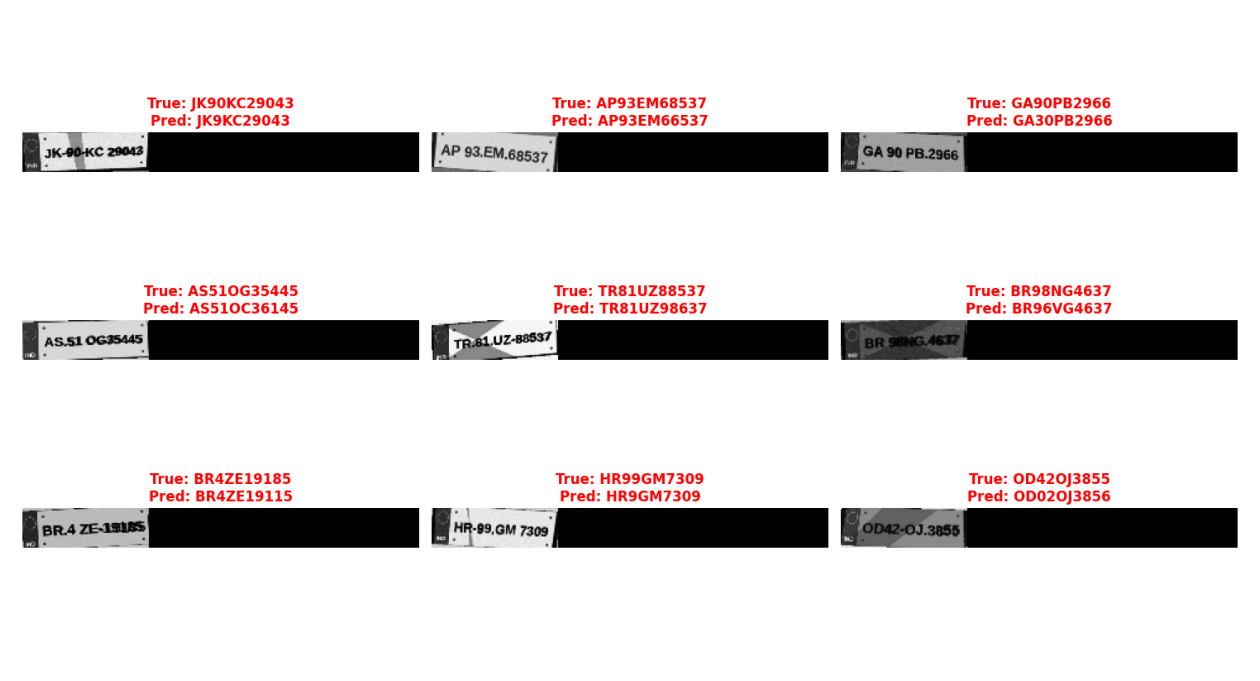

In [20]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("/kaggle/working/error_analysis.png")

plt.figure(figsize=(16, 10))
plt.imshow(img)
plt.axis("off")
plt.show()


In [9]:
import shutil
shutil.make_archive("checkpoints", 'zip', "checkpoints")
from IPython.display import FileLink
FileLink(r'checkpoints.zip')

/kaggle/working/checkpoints.zip